<a href="https://colab.research.google.com/github/moter1026/review_Kinopoisk_lab5/blob/main/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nlpaug


Импортирую необходимые библиотеки и получаю все отзывы из заранее созданного csv файла

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from typing import Tuple, Any
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import math
import random
import nlpaug.augmenter.word as npw

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from google.colab import drive
import sys

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
sys.path.insert(0, "/content/drive/MyDrive/lab5_drive")
%cd /content/drive/MyDrive/lab5_drive/

allTextsDf = pd.read_csv("/content/drive/MyDrive/lab5_drive/big_description.csv")
print(allTextsDf)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/lab5_drive
                                           text of file class
0     Форрест Гамп\n\n\n\nФоррест Гамп – не совсем о...  good
1     Форрест Гамп\n\n\n\nСразу хочу сказать, что по...  good
2     Форрест Гамп\n\n\n\nКогда я сажусь смотреть ка...  good
3     Форрест Гамп\n\n\n\nВпервые посмотрев этот фил...  good
4     Форрест Гамп\n\n\n\nНе поспоришь - Том Хэнкс г...  good
...                                                 ...   ...
2123  Зеленая миля\n\n\n\nФильм не оправдал ожиданий...   bad
2124  Зеленая миля\n\n\n\nФактически фильм начинаетс...   bad
2125  Зеленая миля\n\n\n\n'Уж сколько раз твердили м...   bad
2126  Зеленая миля\n\n\n\nНе буду повторяться за пре...   bad
2127  Зеленая миля\n\n\n\nЧего ожидаешь, когда садиш...   bad

[2128 rows x 2 columns]


произвожу преобразование текста в нужный вид:

*   удаляю не буквенные символы
*   токенизирую (разбиваю текст на слова)
*   лемматизирую (привожу слова к базовой форме)
*   Удаляю стоп слова
*   объединяю токены через пробел

In [3]:
def remove_non_alphabets(x) -> str:
  return re.sub(r'[^a-zA-Zа-яА-Я]', ' ', x)


In [4]:
tokenize = lambda x: word_tokenize(x, language="russian")

In [5]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [6]:
def delete_stop_words(text_list: list) -> list:
  return [word for word in text_list if word.lower() not in stopwords.words('russian')]

In [7]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

print('Processing : [=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(remove_non_alphabets)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(tokenize) # [ word_tokenize(row) for row in data['text']]
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(leammtizer)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(delete_stop_words)
print('=', end='')
allTextsDf['text of file'] = allTextsDf['text of file'].apply(lambda x: ' '.join(x))
print('] : Completed', end='')
allTextsDf.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Processing : [=====] : Completed

,text of file,class
0,Форрест Гамп Форрест Гамп обычный человек отст...,good
1,Форрест Гамп Сразу хочу сказать посмотрел филь...,good
2,Форрест Гамп сажусь смотреть расхваленный всем...,good
3,Форрест Гамп Впервые посмотрев фильм долго мог...,good
4,Форрест Гамп поспоришь Хэнкс гениален неважно ...,good


заменяю названия классов на числа

In [8]:
def change_labels(x: Any):
  # print(x)
  if x == 'good' or x == 1:
    return 1
  else:
    return 0
allTextsDf['class'] = allTextsDf['class'].apply(change_labels)
print(allTextsDf)

                                           text of file  class
0     Форрест Гамп Форрест Гамп обычный человек отст...      1
1     Форрест Гамп Сразу хочу сказать посмотрел филь...      1
2     Форрест Гамп сажусь смотреть расхваленный всем...      1
3     Форрест Гамп Впервые посмотрев фильм долго мог...      1
4     Форрест Гамп поспоришь Хэнкс гениален неважно ...      1
...                                                 ...    ...
2123  Зеленая миля Фильм оправдал ожиданий Сюжет абс...      0
2124  Зеленая миля Фактически фильм начинается момен...      0
2125  Зеленая миля сколько твердили миру лесть гнусн...      0
2126  Зеленая миля буду повторяться предыдущими крас...      0
2127  Зеленая миля ожидаешь садишься смотреть фильм ...      0

[2128 rows x 2 columns]


векторизация

In [576]:
max_words = 2000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(allTextsDf['text of file']).toarray()
sparse_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [577]:
sparse_matrix.shape

(2128, 2000)

разбиваю датасет на части для тренировки, тестирования и валидации

In [578]:
x_train, x_temp, y_train, y_temp = train_test_split(sparse_matrix, np.array(allTextsDf['class']), test_size=0.2, random_state=42)

# Разделение временной выборки на тестовую и валидационную выборки
x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

создаём тензоры из NumPy массивоы и оборачиваем их в переменные PyTorch

In [579]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()
x_valid = Variable(torch.from_numpy(x_valid)).float()
y_valid = Variable(torch.from_numpy(y_valid)).long()

создаём датасеты из тензорных переменных для обучения нейронной сети

In [580]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)
test_dataset = TensorDataset(x_test, y_test)

In [581]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Создаём класс для построения нейронной сети, где описываются все принципы, по которым будут данные будут перемещаться по ней

In [594]:
class TextNet(nn.Module):
  def __init__(self):
    super(TextNet, self).__init__()
    self.func1 = nn.Linear(2000, 20)
    self.func2 = nn.Linear(20, 5)
    self.func3 = nn.Linear(5, 2)

  def forward(self, x):
    x = F.relu(self.func1(x))
    x = F.relu(self.func2(x))
    x = self.func3(x)
    return x


создание экземпляра класса построения нейронки

In [606]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = 50
loss_values = []
models = []


Epoch 1/50, Training Loss: 0.6854, Training Accuracy: 0.5259, Validation Loss: 0.6677, Validation Accuracy: 0.5962
Epoch 2/50, Training Loss: 0.6191, Training Accuracy: 0.7914, Validation Loss: 0.5932, Validation Accuracy: 0.8638
Epoch 3/50, Training Loss: 0.5352, Training Accuracy: 0.9060, Validation Loss: 0.5194, Validation Accuracy: 0.9296
Epoch 4/50, Training Loss: 0.4651, Training Accuracy: 0.9454, Validation Loss: 0.4619, Validation Accuracy: 0.9390
Epoch 5/50, Training Loss: 0.4064, Training Accuracy: 0.9542, Validation Loss: 0.4166, Validation Accuracy: 0.9437
Epoch 6/50, Training Loss: 0.3583, Training Accuracy: 0.9559, Validation Loss: 0.3702, Validation Accuracy: 0.9390
Epoch 7/50, Training Loss: 0.3180, Training Accuracy: 0.9577, Validation Loss: 0.3301, Validation Accuracy: 0.9531
Epoch 8/50, Training Loss: 0.2806, Training Accuracy: 0.9642, Validation Loss: 0.2976, Validation Accuracy: 0.9484
Epoch 9/50, Training Loss: 0.2454, Training Accuracy: 0.9671, Validation Loss: 0

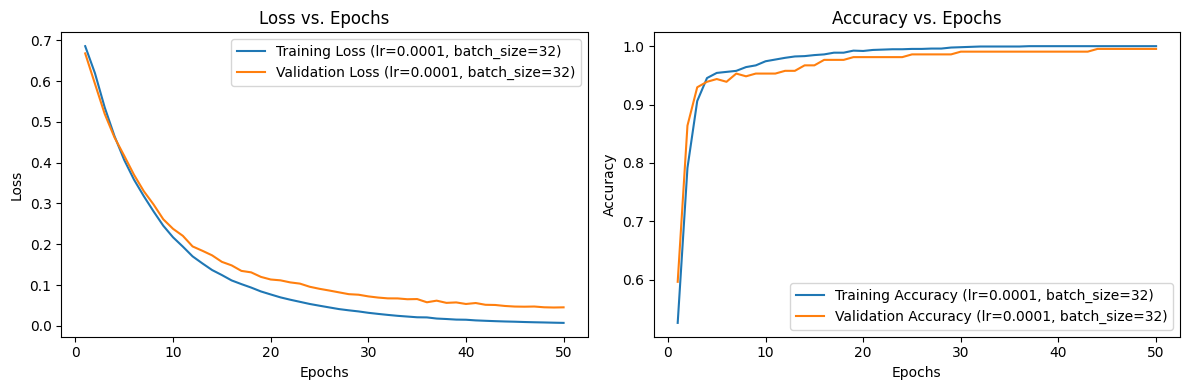

Epoch 1/50, Training Loss: 0.7630, Training Accuracy: 0.4747, Validation Loss: 0.7530, Validation Accuracy: 0.4554
Epoch 2/50, Training Loss: 0.7423, Training Accuracy: 0.4747, Validation Loss: 0.7641, Validation Accuracy: 0.4554
Epoch 3/50, Training Loss: 0.7197, Training Accuracy: 0.4753, Validation Loss: 0.7447, Validation Accuracy: 0.4554
Epoch 4/50, Training Loss: 0.6933, Training Accuracy: 0.4777, Validation Loss: 0.6892, Validation Accuracy: 0.4554
Epoch 5/50, Training Loss: 0.6670, Training Accuracy: 0.4900, Validation Loss: 0.6863, Validation Accuracy: 0.4648
Epoch 6/50, Training Loss: 0.6385, Training Accuracy: 0.5264, Validation Loss: 0.6569, Validation Accuracy: 0.5023
Epoch 7/50, Training Loss: 0.6105, Training Accuracy: 0.5776, Validation Loss: 0.6218, Validation Accuracy: 0.5493
Epoch 8/50, Training Loss: 0.5813, Training Accuracy: 0.6328, Validation Loss: 0.6043, Validation Accuracy: 0.5962
Epoch 9/50, Training Loss: 0.5523, Training Accuracy: 0.6915, Validation Loss: 0

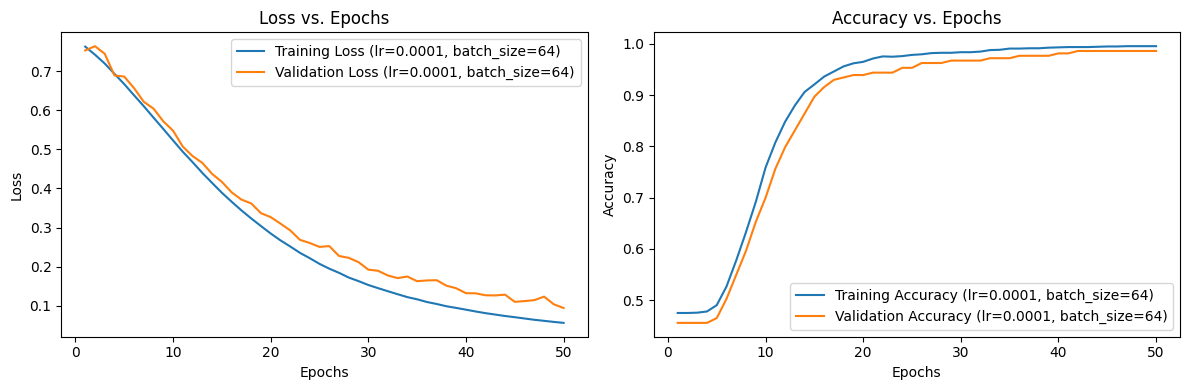

Epoch 1/50, Training Loss: 0.6922, Training Accuracy: 0.5253, Validation Loss: 0.6822, Validation Accuracy: 0.5446
Epoch 2/50, Training Loss: 0.6804, Training Accuracy: 0.5253, Validation Loss: 0.6711, Validation Accuracy: 0.5493
Epoch 3/50, Training Loss: 0.6657, Training Accuracy: 0.5264, Validation Loss: 0.6569, Validation Accuracy: 0.5587
Epoch 4/50, Training Loss: 0.6447, Training Accuracy: 0.5411, Validation Loss: 0.6308, Validation Accuracy: 0.5869
Epoch 5/50, Training Loss: 0.6186, Training Accuracy: 0.5928, Validation Loss: 0.6077, Validation Accuracy: 0.6620
Epoch 6/50, Training Loss: 0.5880, Training Accuracy: 0.6751, Validation Loss: 0.5794, Validation Accuracy: 0.7418
Epoch 7/50, Training Loss: 0.5556, Training Accuracy: 0.7638, Validation Loss: 0.5538, Validation Accuracy: 0.8028
Epoch 8/50, Training Loss: 0.5245, Training Accuracy: 0.8373, Validation Loss: 0.5192, Validation Accuracy: 0.8451
Epoch 9/50, Training Loss: 0.4933, Training Accuracy: 0.8942, Validation Loss: 0

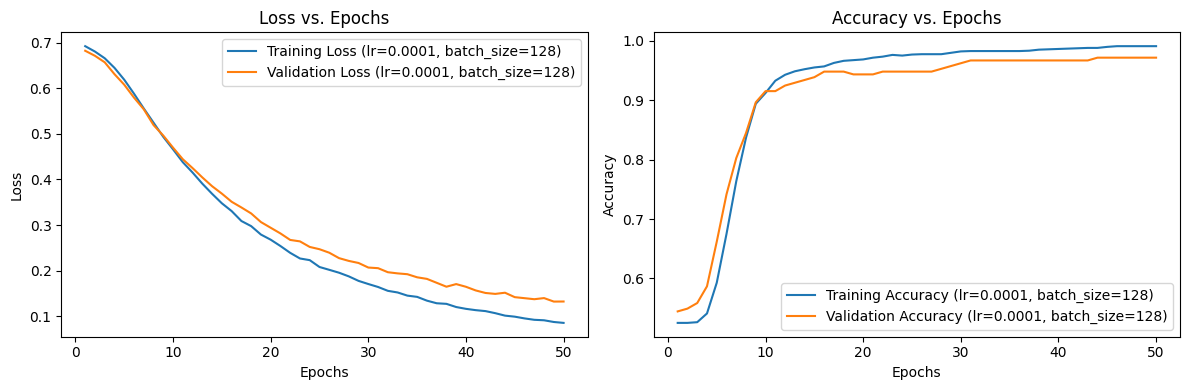

Epoch 1/50, Training Loss: 0.6196, Training Accuracy: 0.5405, Validation Loss: 0.4935, Validation Accuracy: 0.7700
Epoch 2/50, Training Loss: 0.2668, Training Accuracy: 0.9383, Validation Loss: 0.1474, Validation Accuracy: 0.9624
Epoch 3/50, Training Loss: 0.0854, Training Accuracy: 0.9800, Validation Loss: 0.0949, Validation Accuracy: 0.9718
Epoch 4/50, Training Loss: 0.0412, Training Accuracy: 0.9935, Validation Loss: 0.0736, Validation Accuracy: 0.9859
Epoch 5/50, Training Loss: 0.0232, Training Accuracy: 0.9959, Validation Loss: 0.0610, Validation Accuracy: 0.9812
Epoch 6/50, Training Loss: 0.0132, Training Accuracy: 0.9994, Validation Loss: 0.0532, Validation Accuracy: 0.9906
Epoch 7/50, Training Loss: 0.0076, Training Accuracy: 1.0000, Validation Loss: 0.0470, Validation Accuracy: 0.9906
Epoch 8/50, Training Loss: 0.0051, Training Accuracy: 1.0000, Validation Loss: 0.0433, Validation Accuracy: 0.9906
Epoch 9/50, Training Loss: 0.0038, Training Accuracy: 1.0000, Validation Loss: 0

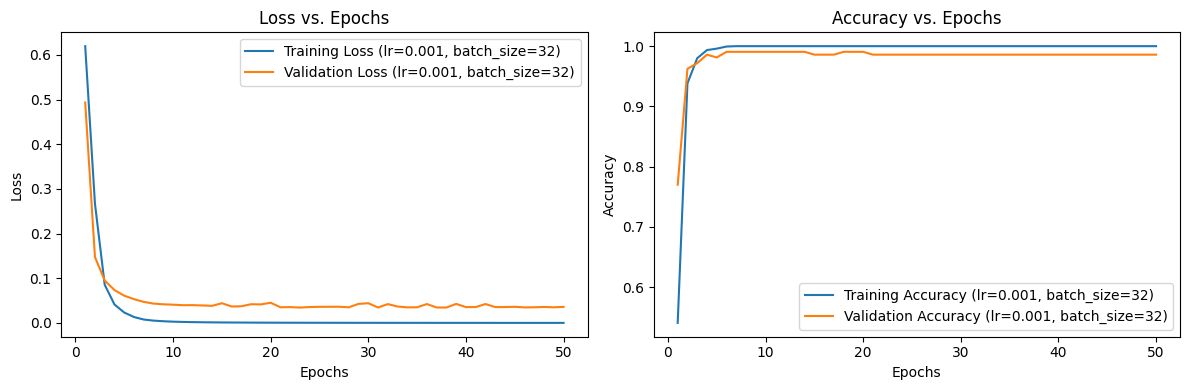

Epoch 1/50, Training Loss: 0.6145, Training Accuracy: 0.5335, Validation Loss: 0.4959, Validation Accuracy: 0.6714
Epoch 2/50, Training Loss: 0.3633, Training Accuracy: 0.8848, Validation Loss: 0.2580, Validation Accuracy: 0.9531
Epoch 3/50, Training Loss: 0.1649, Training Accuracy: 0.9741, Validation Loss: 0.1497, Validation Accuracy: 0.9671
Epoch 4/50, Training Loss: 0.0888, Training Accuracy: 0.9830, Validation Loss: 0.1035, Validation Accuracy: 0.9765
Epoch 5/50, Training Loss: 0.0539, Training Accuracy: 0.9924, Validation Loss: 0.0850, Validation Accuracy: 0.9859
Epoch 6/50, Training Loss: 0.0357, Training Accuracy: 0.9959, Validation Loss: 0.0703, Validation Accuracy: 0.9859
Epoch 7/50, Training Loss: 0.0234, Training Accuracy: 0.9982, Validation Loss: 0.0562, Validation Accuracy: 0.9906
Epoch 8/50, Training Loss: 0.0163, Training Accuracy: 1.0000, Validation Loss: 0.0679, Validation Accuracy: 0.9906
Epoch 9/50, Training Loss: 0.0119, Training Accuracy: 1.0000, Validation Loss: 0

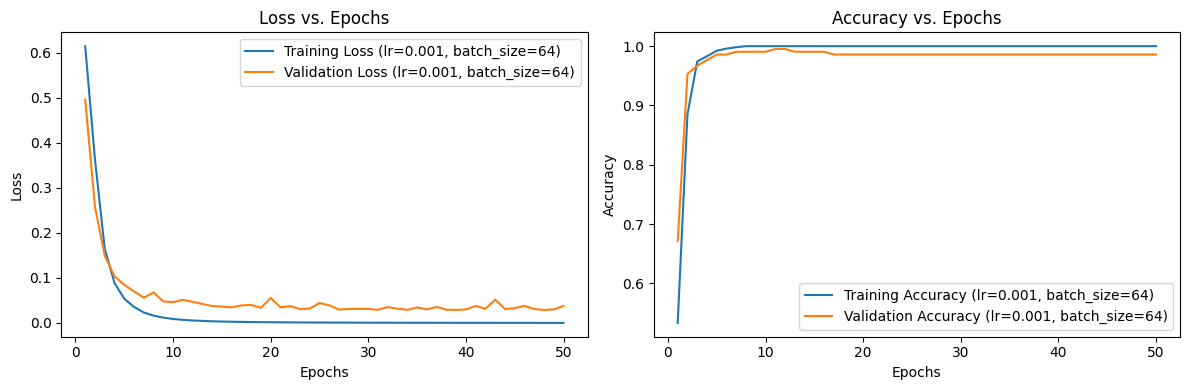

Epoch 1/50, Training Loss: 0.6658, Training Accuracy: 0.5306, Validation Loss: 0.5958, Validation Accuracy: 0.6150
Epoch 2/50, Training Loss: 0.5233, Training Accuracy: 0.7344, Validation Loss: 0.4541, Validation Accuracy: 0.8545
Epoch 3/50, Training Loss: 0.3698, Training Accuracy: 0.9289, Validation Loss: 0.3240, Validation Accuracy: 0.9437
Epoch 4/50, Training Loss: 0.2432, Training Accuracy: 0.9642, Validation Loss: 0.2338, Validation Accuracy: 0.9531
Epoch 5/50, Training Loss: 0.1616, Training Accuracy: 0.9753, Validation Loss: 0.1783, Validation Accuracy: 0.9577
Epoch 6/50, Training Loss: 0.1141, Training Accuracy: 0.9812, Validation Loss: 0.1347, Validation Accuracy: 0.9671
Epoch 7/50, Training Loss: 0.0864, Training Accuracy: 0.9859, Validation Loss: 0.1118, Validation Accuracy: 0.9812
Epoch 8/50, Training Loss: 0.0668, Training Accuracy: 0.9906, Validation Loss: 0.0987, Validation Accuracy: 0.9812
Epoch 9/50, Training Loss: 0.0503, Training Accuracy: 0.9947, Validation Loss: 0

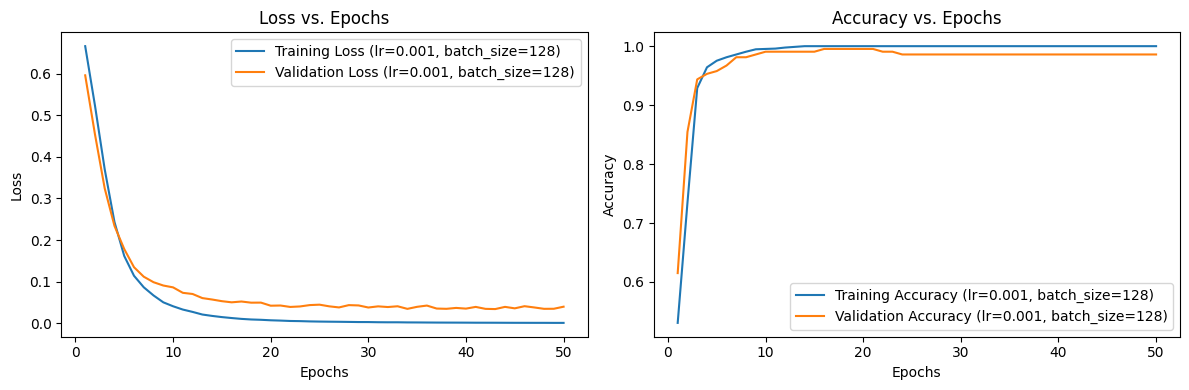

Epoch 1/50, Training Loss: 0.2250, Training Accuracy: 0.9036, Validation Loss: 0.1114, Validation Accuracy: 0.9624
Epoch 2/50, Training Loss: 0.0205, Training Accuracy: 0.9959, Validation Loss: 0.0635, Validation Accuracy: 0.9765
Epoch 3/50, Training Loss: 0.0021, Training Accuracy: 1.0000, Validation Loss: 0.0672, Validation Accuracy: 0.9765
Epoch 4/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 0.0770, Validation Accuracy: 0.9812
Epoch 5/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0.0756, Validation Accuracy: 0.9812
Epoch 6/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0.0854, Validation Accuracy: 0.9765
Epoch 7/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0.0853, Validation Accuracy: 0.9765
Epoch 8/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Loss: 0.0905, Validation Accuracy: 0.9765
Epoch 9/50, Training Loss: 0.0000, Training Accuracy: 1.0000, Validation Loss: 0

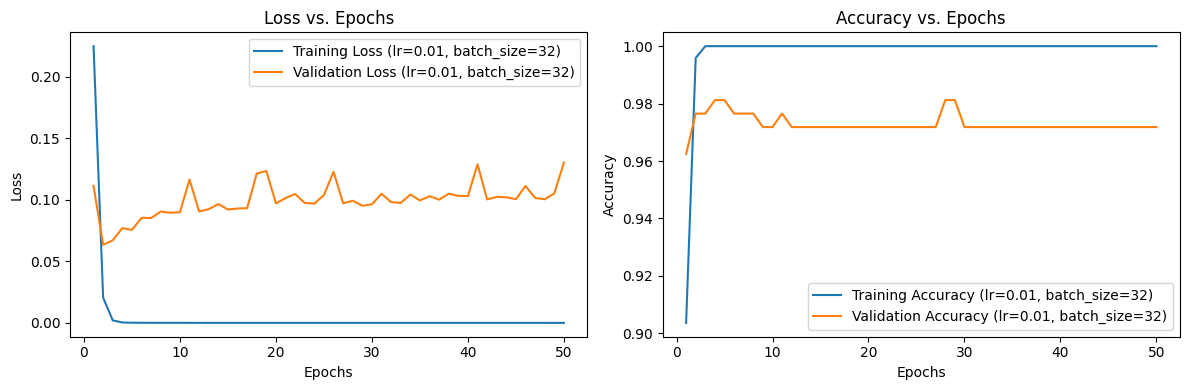

Epoch 1/50, Training Loss: 0.2454, Training Accuracy: 0.9072, Validation Loss: 0.1807, Validation Accuracy: 0.9484
Epoch 2/50, Training Loss: 0.0454, Training Accuracy: 0.9859, Validation Loss: 0.0651, Validation Accuracy: 0.9671
Epoch 3/50, Training Loss: 0.0144, Training Accuracy: 0.9976, Validation Loss: 0.1118, Validation Accuracy: 0.9718
Epoch 4/50, Training Loss: 0.0037, Training Accuracy: 0.9994, Validation Loss: 0.0858, Validation Accuracy: 0.9718
Epoch 5/50, Training Loss: 0.0010, Training Accuracy: 1.0000, Validation Loss: 0.0783, Validation Accuracy: 0.9718
Epoch 6/50, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Loss: 0.1000, Validation Accuracy: 0.9718
Epoch 7/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 0.1061, Validation Accuracy: 0.9718
Epoch 8/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 0.0795, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 0

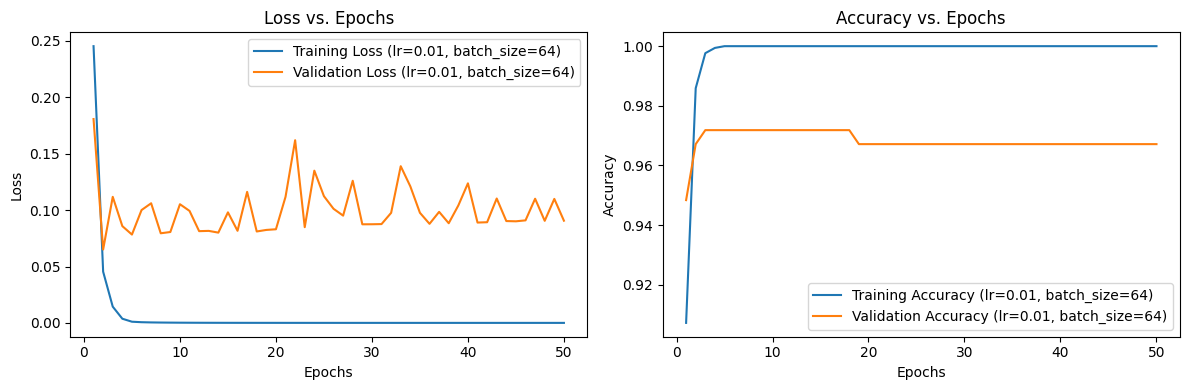

Epoch 1/50, Training Loss: 0.2963, Training Accuracy: 0.8895, Validation Loss: 0.0815, Validation Accuracy: 0.9671
Epoch 2/50, Training Loss: 0.0409, Training Accuracy: 0.9853, Validation Loss: 0.0668, Validation Accuracy: 0.9718
Epoch 3/50, Training Loss: 0.0058, Training Accuracy: 0.9988, Validation Loss: 0.0538, Validation Accuracy: 0.9624
Epoch 4/50, Training Loss: 0.0012, Training Accuracy: 1.0000, Validation Loss: 0.0641, Validation Accuracy: 0.9577
Epoch 5/50, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Loss: 0.0564, Validation Accuracy: 0.9624
Epoch 6/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Loss: 0.0493, Validation Accuracy: 0.9671
Epoch 7/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Loss: 0.0504, Validation Accuracy: 0.9718
Epoch 8/50, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 0.0524, Validation Accuracy: 0.9718
Epoch 9/50, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Loss: 0

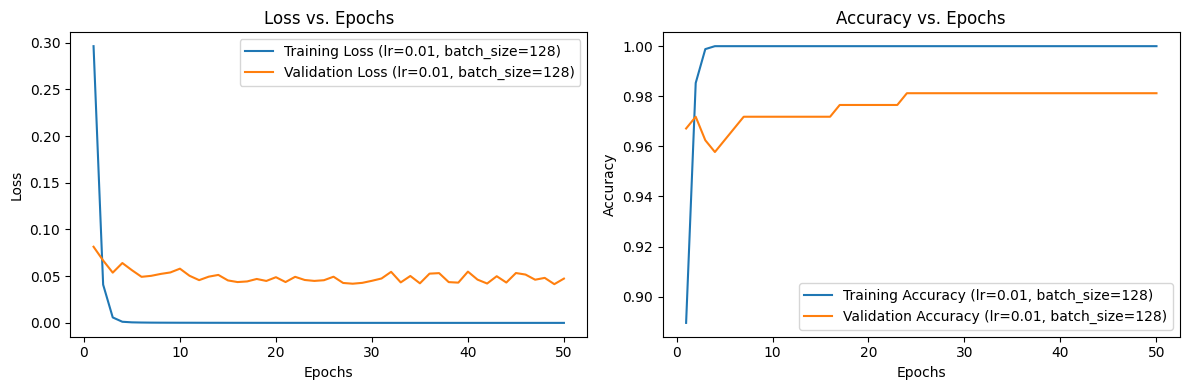

Test Accuracy: 0.9765


In [607]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        model = TextNet()  # Create an instance of your model
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
        train_losses = []
        valid_losses = []
        train_accuracy = []
        valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            train_losses.append(running_loss / len(train_loader))
            train_accuracy.append(correct_train / total_train)

            # Validation
            model.eval()

            running_loss = 0.0
            correct_valid = 0
            total_valid = 0

            with torch.no_grad():
                for inputs, labels in valid_loader:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    total_valid += labels.size(0)
                    correct_valid += (predicted == labels).sum().item()

                valid_losses.append(running_loss / len(valid_loader))
                valid_accuracy.append(correct_valid / total_valid)

                print(f'Epoch {epoch + 1}/{epochs}, '
                      f'Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}, '
                      f'Validation Loss: {valid_losses[-1]:.4f}, Validation Accuracy: {valid_accuracy[-1]:.4f}')
                models.append(model)

        # Visualization
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), train_losses, label=f'Training Loss (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_losses, label=f'Validation Loss (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epochs')

        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), train_accuracy, label=f'Training Accuracy (lr={lr}, batch_size={batch_size})')
        plt.plot(range(1, epochs + 1), valid_accuracy, label=f'Validation Accuracy (lr={lr}, batch_size={batch_size})')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs. Epochs')

        plt.tight_layout()
        plt.show()

# Evaluate model on the test set
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

выбрав лучшие learning_rates и batch_size обучаю нейронную сеть для проверки работоспособности

In [596]:
batch_size = 32
lr = 0.001
model = TextNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Training loop
train_losses = []
valid_losses = []
train_accuracy = []
valid_accuracy = []

epochs = 20

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy.append(correct_train / total_train)

            # Validation
    model.eval()

    running_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

        valid_losses.append(running_loss / len(valid_loader))
        valid_accuracy.append(correct_valid / total_valid)

In [597]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'model.pth')

Оценка отзыва моделью

In [598]:
sample_review = """
Невероятное аниме... Сюрреалистичны даже характеры персонажей. Визуально творится такой психоделический беспредел, что по ходу просмотра то и дело хочется произнести: 'Да вы что, это серьёзно?'

Пацифистско-пофигистский мульт из мира цветных снов, куда в конце концов всё возвращается. С глубоким смысловым визуальным рядом, но отсылки к оккультизму и символике смерти здесь подобен красивому фантику. Демон Кальцифер, на котором держится не только ходячий замок, но и весь мульт, - это по сути сублимация по Фрейду. Истории снятия проклятия с Софи в нашей реальности соответствует психотерапевтическая работа по обновлению отношений в союзе простушки с 'аристократом духа'. 'Ведьму пустоши' нейтрализует личностный рост и обгон по социальной лестнице.

Детям-то как раз смотреть можно и нужно, потому что деструктивность здесь вовсе не утверждается, совсем наоборот: именитесь к лучшему, и мир изменится вокруг вас. Да и вообще какая волшебная сказка обходится без ведьм и колдунов, добрых и злых духов?
"""

In [599]:
sample_review = remove_non_alphabets(sample_review)
sample_review = tokenize(sample_review)
sample_review = delete_stop_words(sample_review)
sample_review = leammtizer(sample_review)
sample_review = ' '.join(sample_review)


In [600]:
sample_review

'Невероятное аниме Сюрреалистичны характеры персонажей Визуально творится психоделический беспредел ходу просмотра дело хочется произнести это серь зно Пацифистско пофигистский мульт мира цветных снов конце концов вс возвращается глубоким смысловым визуальным рядом отсылки оккультизму символике смерти подобен красивому фантику Демон Кальцифер котором держится ходячий замок весь мульт это сути сублимация Фрейду Истории снятия проклятия Софи нашей реальности соответствует психотерапевтическая работа обновлению отношений союзе простушки аристократом духа Ведьму пустоши нейтрализует личностный рост обгон социальной лестнице Детям смотреть нужно деструктивность вовсе утверждается наоборот именитесь лучшему мир изменится вокруг вообще волшебная сказка обходится ведьм колдунов добрых злых духов'

In [601]:
max_words = 2000
cv = CountVectorizer(max_features=max_words)
sparse_matrix = cv.fit_transform(np.array([sample_review])).toarray()
if sparse_matrix.shape[1] < 2000:
    sparse_matrix = np.pad(sparse_matrix, ((0, 0), (0, 2000 - sparse_matrix.shape[1])))
sparse_matrix.shape

(1, 2000)

In [602]:
review = Variable(torch.from_numpy(sparse_matrix)).float()

загружаем предварительно обученную нейронку и состояние оптимизатора для модели из файла 'model.pth'

In [603]:
model = TextNet()
loaded_checkpoint = torch.load('model.pth')
model.load_state_dict(loaded_checkpoint['model_state_dict'])
optimizer.load_state_dict(loaded_checkpoint['optimizer_state_dict'])
epoch = loaded_checkpoint['epoch']

model.eval()

TextNet(
  (func1): Linear(in_features=2000, out_features=20, bias=True)
  (func2): Linear(in_features=20, out_features=5, bias=True)
  (func3): Linear(in_features=5, out_features=2, bias=True)
)

In [604]:
with torch.no_grad():
    output = model(review)
    print('output: ', output)


predicted_class = torch.argmax(output).item()

print(f"Предсказанная оценка: {predicted_class}")

output:  tensor([[ 0.0538, -0.9267]])
Предсказанная оценка: 0
